In [1]:
%load_ext autoreload
%autoreload 2


%pylab inline

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import tqdm
import torch
import yaml

from models import VAE_3D, VQ_VAE, PixelCNN_VQVAE
from utils import get_dataloader

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
BS = 64
img_size = 128
dataloader, classes = get_dataloader(img_size = 128,batch_size = BS)
device = torch.device('cuda')

print(classes)


['cat', 'dog', 'wild']


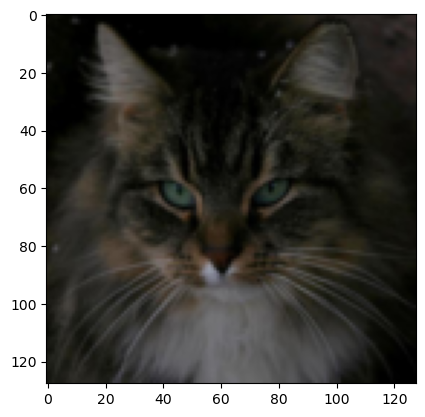

In [3]:
imshow((dataloader.dataset[0][0]/2+.5).permute(1,2,0).numpy())

In [4]:
with open('./VAE_AFHQ_params.yaml', 'rb') as f:
    config = yaml.safe_load(f)

model = VAE_3D(config['model parameters'])
model = model.to(device)

In [5]:
criterion = nn.MSELoss()
lr = 0.0002

weight_decay = 1e-4

optim = torch.optim.AdamW(model.parameters(), lr = lr, weight_decay=weight_decay)

kl_weight = 0.0001
epochs = 20


def loss_function(x, x_pred, mu, logvar, kl_weight = 1, criterion = torch.nn.MSELoss()):
    loss = criterion(x_pred, x) - kl_weight * 0.5 * torch.mean(1-torch.exp(logvar) - mu**2 + logvar)
    
    return loss




In [6]:
losses = []
model.train()

for _ in range(epochs):
    pbar = tqdm.tqdm(dataloader)
    for batch, _ in pbar:
        x = batch.to(device)

        out, mu, logvar = model(x)
        optim.zero_grad()
        
        loss = loss_function(x, out, mu, logvar, kl_weight=kl_weight)

        loss.backward()
        optim.step()

        losses.append(loss.item())

        pbar.set_description(f'Loss: %.3f' % loss.item())   


Loss: 0.126: 100%|██████████| 229/229 [02:37<00:00,  1.45it/s]


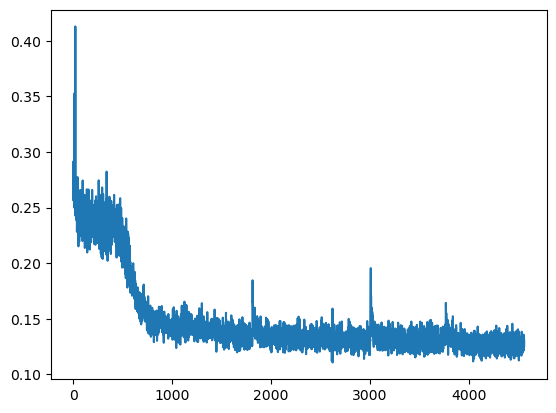

In [12]:
plot(losses[20:])

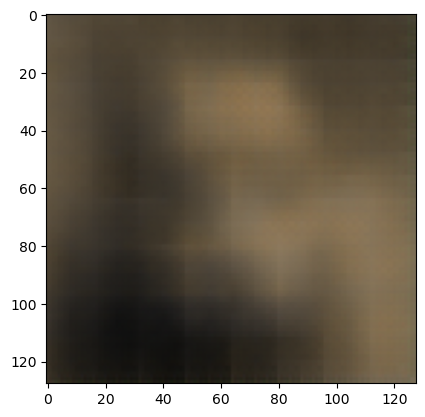

In [18]:
model.eval()
img_gen = model.sample(1)

imshow((img_gen[0]/2 +.5).cpu().permute(1,2,0).numpy())

In [19]:
test_dataloader, _ = get_dataloader(img_size = 128,batch_size = BS, split = 'val')


In [20]:
batch = next(iter(test_dataloader))[0]
with torch.no_grad():
    x_pred, mu, logvar = model(batch.to(device).float())
    loss = loss_function(batch.to(device), x_pred, mu, logvar, kl_weight=kl_weight)

In [21]:
loss

tensor(0.1250, device='cuda:0')

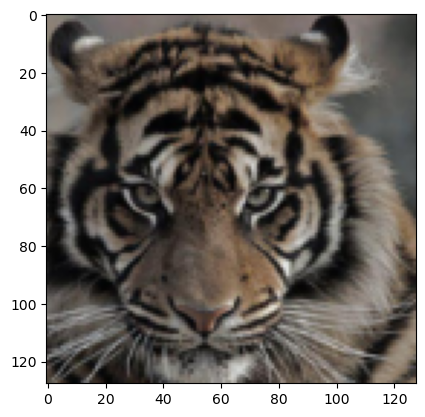

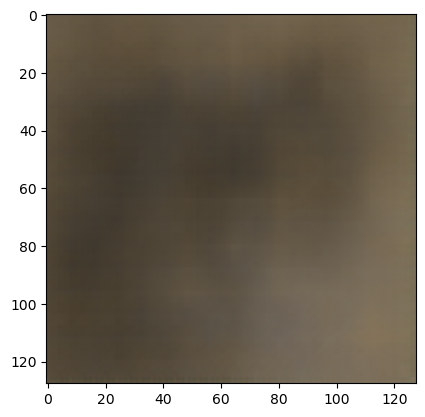

In [26]:
imshow((batch[0]/2+.5).cpu().permute(1,2,0).numpy())
show()
imshow((x_pred[0]/2+.5).cpu().permute(1,2,0).numpy())


In [25]:
torch.max(x_pred)

tensor(1., device='cuda:0')